In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip

--2021-05-15 14:06:32--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.25.236
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.25.236|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  43.8MB/s    in 2m 25s  

2021-05-15 14:08:58 (43.7 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]



In [ ]:
%rm -rf main

In [ ]:
!unzip val2014.zip -d /content/main

Streaming output truncated to the last 5000 lines.
 extracting: /content/main/val2014/COCO_val2014_000000535608.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000279145.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000243495.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000225791.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000428067.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000059383.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000558498.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000376123.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000191304.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000171062.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000014549.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000121152.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000276596.jpg  
 extracting: /content/main/val2014/COCO_val2014_000000029431.jpg  
 extracting

In [ ]:
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

--2021-05-15 14:12:07--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... ^C


In [3]:
import torch 
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torchvision import datasets
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random

In [4]:
def load_image(path):
  img = cv2.imread(path)
  return img

In [5]:

def show(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = np.array(img / 255).clip(0, 1)
  plt.imshow(img)
  plt.show()

In [6]:
def save_image(img, path):
  img = img.clip(0, 255)
  cv2.imwrite(path, img)

In [7]:
def itoi(img, max_size = None):
  if max_size == None:
    tfs = transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Lambda(lambda x: x.mul(255))
    ])

  else:
    H, W, C = img.shape
    img_size = tuple([int((float(max_size) / max(H, W))*x) for x in [H, W]])
    tfs = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Resize(img_size),
                              transforms.ToTensor(),
                              transforms.Lambda(lambda x: x.mul(255))
    ])

  return tfs(img)

In [8]:
def toti(tensor):
  tensor = tensor.squeeze()
  img = tensor.cpu().numpy()
  return img.transpose(1, 2, 0)
  

In [11]:
class TransformerNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        conv_layer(3, 32, 9, 1),
        conv_layer(32, 64, 3, 2),
        conv_layer(64, 128, 3, 2),
        ResBlock(128, 3),
        ResBlock(128, 3),
        ResBlock(128, 3),
        ResBlock(128, 3),
        DeConv(128, 64, 3, 2, 1),
        nn.ReLU(),
        DeConv(64, 32, 3, 2, 1),
        nn.ReLU(),
        conv_layer(32, 3, 9, 1)[:-2]
    )

  def forward(self, x):
    return self.main(x)

In [12]:
def conv_layer(in_ch, out_ch, kernel_size, stride):
  rp = kernel_size // 2
  return nn.Sequential(
      nn.ReflectionPad2d(rp),
      nn.Conv2d(in_ch, out_ch, kernel_size, stride),
      nn.InstanceNorm2d(out_ch, affine = True),
      nn.ReLU()
  )

In [13]:
class ResBlock(nn.Module):

  def __init__(self, channels = 128, kernel_size = 3):
    super().__init__()
    self.conv1 = conv_layer(channels, channels, kernel_size, stride = 1)
    self.conv2 = conv_layer(channels, channels, kernel_size, stride = 1)[:-1]
  
  def forward(self, x):
    return x + self.conv2(self.conv1(x))

In [14]:
class DeConv(nn.Module):

  def __init__(self, in_ch, out_ch, kernel_size, stride, out_padding):
    super().__init__()
    padding_size = kernel_size // 2
    self.convT = nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride, padding_size, out_padding)
    self.norm = nn.InstanceNorm2d(out_ch, affine = True)

  def forward(self, x):
    return self.norm(self.convT(x))


In [ ]:
class VGG16(nn.Module):
    def __init__(self, vgg_path="models/vgg16-00b39a1b.pth"):
        super(VGG16, self).__init__()
        vgg16_ = models.vgg16(pretrained=False)
        vgg16_.load_state_dict(torch.load(vgg_path), strict=False)
        vgg16_.eval()
        self.features = vgg16_.features

        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        layers = {'3': 'relu1_2', '8': 'relu2_2', '15': 'relu3_3', '22': 'relu4_3'}
        features = {}
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
                if (name=='22'):
                    break

        return features

In [ ]:
def gram_matrix(data):
  b, c, h, w = data.shape
  x = data.view(b, c, h*w)
  xt = x.transpose(1, 2)
  return torch.bmm(x, xt) / (c * w * h)

In [ ]:
def tv_loss(img_batch):
    batch_size = img_batch.shape[0]
    return (torch.sum(torch.abs(img_batch[:, :, :, :-1] - img_batch[:, :, :, 1:])) + torch.sum(torch.abs(img_batch[:, :, :-1, :] - img_batch[:, :, 1:, :]))) / batch_size

In [ ]:
IMG_SIZE = 256
DATASET_PATH = '/content/main'
BATCH_SIZE = 4
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 15
TV_WEIGHT = 1e-6
LR = 1e-3
SEED = 35
'''
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
'''

'\ntorch.manual_seed(SEED)\ntorch.cuda.manual_seed(SEED)\nnp.random.seed(SEED)\nrandom.seed(SEED)\n'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
                                transforms.Resize(IMG_SIZE),
                                transforms.CenterCrop(IMG_SIZE),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.mul(255))
])

In [ ]:
train_dataset = datasets.ImageFolder(DATASET_PATH, transform)
train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle = True)

In [ ]:
imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)

In [ ]:
style_image = load_image('painting.jpg')

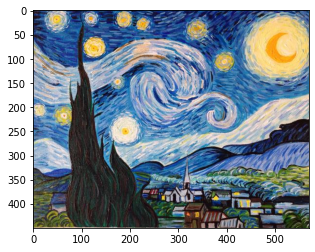

In [ ]:
show(style_image)

In [ ]:
style_tensor = itoi(style_image, 256).to(device).add(imagenet_neg_mean)

In [ ]:
vgg = VGG16('/content/drive/MyDrive/vgg16-00b39a1b.pth').to(device)

In [ ]:
t_net = TransformerNet().to(device)

In [ ]:
b, c, h, w = style_tensor.shape

In [ ]:
style_features = vgg(style_tensor.expand([BATCH_SIZE, c, h, w]))

In [ ]:
style_gram = {}
for key, value in style_features.items():
  style_gram[key] = gram_matrix(value)

In [ ]:
optimizer = torch.optim.Adam(t_net.parameters(), lr = LR)

In [ ]:
criterion = nn.MSELoss().to(device)

In [ ]:
!rm -rf models
!mkdir models

Content_loss = inf
Style_loss = inf


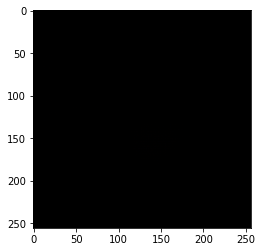

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 241442.953125
Style_loss = 32663178.0


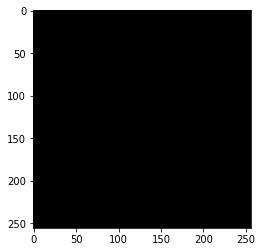

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 239215.6875
Style_loss = 32630636.0


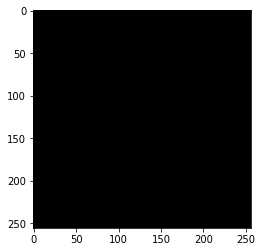

####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Content_loss = 238500.609375
Style_loss = 32619762.0


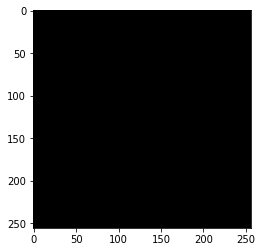

############################################################################################################################################################################################################################################################################################################################################################################################################################################################################

KeyboardInterrupt: ignored

In [ ]:
batch_con_loss = 0
batch_style_loss = 0
batch_count = 0

for e in range(2):

  for batch_id, (content_batch, _) in enumerate(train_loader):

    batch_size = content_batch.shape[0]

    optimizer.zero_grad()

    content_batch = content_batch[:, [2, 1, 0]].to(device)

    y = t_net(content_batch)

    content_features = vgg(content_batch.add(imagenet_neg_mean))
    generated_features = vgg(y.add(imagenet_neg_mean))

    content_loss = CONTENT_WEIGHT * criterion(generated_features['relu3_3'], content_features['relu3_3'])
    batch_con_loss += content_loss

    style_loss = 0

    for key, value in generated_features.items():
      style_loss += criterion(gram_matrix(value), ng[key][:batch_size])
    style_loss *= STYLE_WEIGHT
    batch_style_loss += style_loss

    t_loss = tv_loss(y) * TV_WEIGHT

    loss = content_loss + style_loss + t_loss

    loss.backward()
    optimizer.step()

    if batch_count % 500 == 0 or batch_count == len(train_loader):
      print(f'Content_loss = {batch_con_loss/batch_count}')
      print(f'Style_loss = {batch_style_loss/batch_count}')

      torch.save(t_net.state_dict(), f'models/stage{batch_count}.pt')

      temp = y[0].clone().detach().unsqueeze(0)
      out = toti(temp)
      show(out)

    batch_count += 1    
    print('#', end='')

In [21]:
 def stylize():
  device = torch.device('cuda')
  model = TransformerNet().to(device)
  model.load_state_dict(torch.load('models/candy.pt', map_location = device))
  with torch.no_grad():
    torch.cuda.empty_cache()
    content_image = load_image('images/stanford.jpg')
    content_tensor = itoi(content_image, 800).unsqueeze(0).to(device)
    print(content_tensor.shape)
    gen_tensor = model(content_tensor)
    gen_image = toti(gen_tensor)
    show(gen_image)
    save_image(gen_image, './output.jpg')


torch.Size([1, 3, 533, 800])


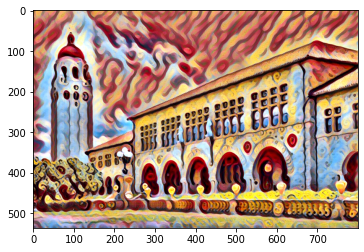

In [22]:
stylize()